<style>
/* Adjust page margins */
body {
    margin-left: 0.1in !important;
    margin-right: 0.1in !important;
}

/* Hide input/output prompts like In [x]: and Out[x]: */
.jp-InputPrompt, .jp-OutputPrompt {
    display: none !important;
}

/* Force DataFrames and tables to auto-fit page width */
.dataframe, table {
    width: 100% !important;
    max-width: 100% !important;
    display: block;
    overflow-x: auto;
    font-size: 85%; /* shrink font a bit */
    word-wrap: break-word;
}

/* Keep plots within page */
.jp-OutputArea-output img {
    max-width: 100% !important;
    height: auto !important;
}
</style>


In [ ]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
pd.set_option("display.max_colwidth", None)

# **Executive Summary**

### **Business Context**

 GreenwallTech Solutions, a SaaS provider, has seen a decline in annual customer retention, threatening recurring revenue. Leadership needs clear, data-driven insights to understand why customers churn and how to prevent it.

The company’s integrated “gold” layer dataset in Microsoft Fabric contains demographics, subscription history, engagement metrics, support records, and churn labels. Leveraging this data, a predictive churn model can:

- Identify the strongest churn drivers.
- Flag high-risk customers for proactive retention.
- Guide targeted business interventions to improve loyalty and lifetime value.

A successful solution will not only help recover retention rates but also optimize resource allocation and strengthen long-term customer relationships.

### **Model Development**

- Data: 5,000 customers from the company’s “gold” layer dataset (demographics, subscriptions, engagement, support, churn labels).
- Preprocessing: Outlier clipping, scaling, one-hot encoding for categorical features, and variance checks ensured clean inputs.
- Feature Engineering: Introduced spend_per_tenure (monthly spend ÷ tenure) to better capture short-term customer value, avoiding inflated lifetime value estimates.
- Multicollinearity: All features showed low VIF (< 2.2), confirming no collinearity concerns.

### **Model Results**

Chosen Model: Logistic Regression selected over Decision Tree and SVM due to interpretability, stable performance, and linear feature relationships.

**Performance:**

- Accuracy: 0.64
- ROC AUC: 0.70 (moderate discrimination)
- Churn recall: 0.64 (captures ~64% of churners)
- Churn precision: 0.51 (about half of flagged churners are true churners)

**Threshold Tuning:**

- Optimal F1-score achieved at threshold ~0.34.
- At 0.45 threshold: Churn recall improved to 78%, but precision dropped to 46%. This reflects a trade-off between catching more churners vs. limiting false alarms.

### **Key Churn Drivers**

**Higher Churn Risk:**

- Basic subscription (+30% odds of churn).
- Longer time since last login (+29%).
- Higher support ticket volume (+14%).
- Customers in East & North regions (+3–5%).

**Lower Churn Risk:**

- High monthly spend (−14% churn odds).
- Longer tenure (−21%).
- Standard subscription type (−20%).
- Customers in West region (−7%).

### **Business Insights**

- Churn is most strongly linked to engagement (logins), subscription type, and support experience.
- High-value, long-tenure customers are naturally “stickier,” while Basic-plan and disengaged customers represent the most urgent churn risks.
- The model ranks customers meaningfully: the top 10% of predicted churn risk are 1.8× more likely to churn than average, enabling efficient resource allocation.

Overall Takeaway: The churn model delivers actionable segmentation, balancing interpretability and predictive accuracy. It provides a foundation for proactive retention campaigns, particularly targeting disengaged Basic-plan customers with frequent support issues, while allowing leadership to prioritize intervention resources where they matter most.

---

In [31]:
#Import of all Libraries used during this case study including custom libraries created by me.

#Default libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

#Cross validation, Calibration & Metrics
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report, roc_auc_score

#Models used
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Custom Libraries from Glazzbocks
from glazzbocks import DataExplorer
from glazzbocks import ModelDiagnostics
from glazzbocks import ModelInterpreter

In [2]:
#Ingest data from csv file
df = pd.read_csv(r"C:\Users\jthom\OneDrive\Documents\GitHub\Bluebeam\GreenwallTech_churn.csv")

In [3]:
#Double checking customer_id is truely unique for all cases before removal 
df['customer_id'].duplicated().sum()

np.int64(0)

In [4]:
#Drop feature no signal to predictive power
df = df.drop(['customer_id'], axis = 1)

In [5]:
#Convert churned from integer to category for summary statistics
df['churned'] = df['churned'].astype('category')

In [6]:
#Instantiating DataExplorer from Glazzbocks library 
eda = DataExplorer(df, 'churned')

### **Categorical Features**

In [7]:
#Summary statistics for categorical features
eda.categorical_summary()

Categorical Feature Summary: 3 columns


,Data Type,Missing (%),# Unique,Most Frequent,Freq (%)
region,object,0.0,4,South,25.78
subscription_type,object,0.0,3,Standard,40.72
churned,category,0.0,2,0,62.56


### Key Inisghts:
- Region Distribution: No single region dominates overwhelmingly, but “South” is the largest segment; may be worth checking if churn varies by region.
- Subscription Concentration: Standard plan is the largest group, which could drive the overall churn pattern if churn is uneven across plans.
- Churn Distribution: Majority of customers are retained (~63%), but churn is still high enough to justify targeted interventions.

No Missing data. No need for imputation methods 

### **Numerical Features**

In [8]:
#Summary statistics for numeric features
eda.numeric_summary()

Dataset Summary: 5,000 rows × 9 columns


,Data Type,Missing (%),Mean,Median,Min,25th %ile,75th %ile,Max,Skewness,Outlier (%)
age,int64,0.00,43.49,44.00,18.0,31.00,56.00,69.00,0.01,0.00
tenure_months,int64,0.00,30.20,30.00,1.0,15.00,45.00,60.00,0.04,0.00
last_login_days_ago,int64,0.00,49.62,50.00,0.0,25.00,75.00,99.00,0.00,0.00
num_support_tickets,int64,0.00,1.52,1.00,0.0,1.00,2.00,7.00,0.79,6.96
monthly_spend,float64,0.00,53.64,49.91,10.0,28.36,73.91,119.99,0.45,0.00
engagement_score,float64,0.00,90.71,100.00,0.0,95.37,100.00,100.00,-2.32,21.18


### Key Insights:
- Engagement Score: Strong negative skew; most customers have very high engagement, but a notable minority have very low scores (~21% outliers).
- Monthly Spend: Mild positive skew; most customers spend moderately, with a small portion spending significantly more.
- Support Tickets: Mild positive skew; the majority raise few tickets, while ~7% are frequent support users.
- Tenure: Balanced distribution, centered around ~30 months, with both short- and long-tenure customers represented.
- Age: Evenly distributed around the mean of 43 years; no extreme skew.
- Last Login: Symmetric distribution, median of 50 days ago.

No Missing data. No need for imputation methods 


### **Correlation Matrix**

Next, I examined feature correlations to identify potential multicollinearity. This helps ensure the model isn't biased by redundant or highly correlated variables.

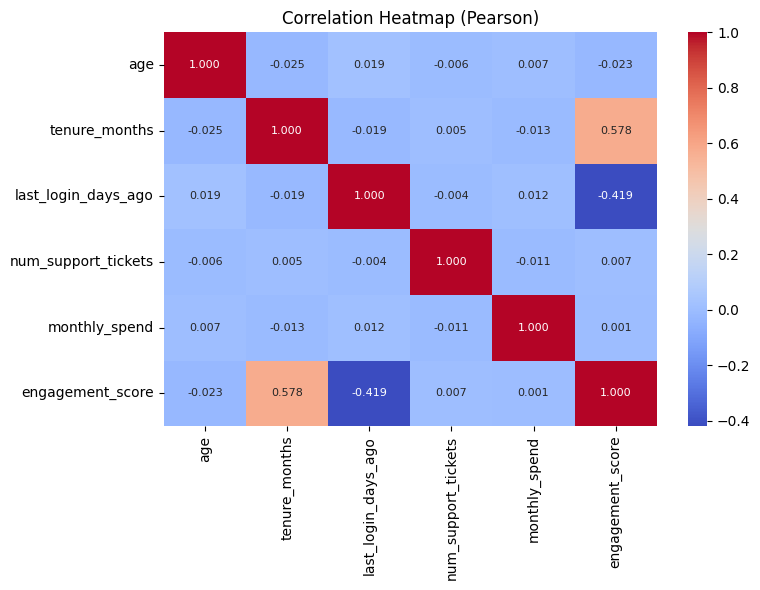

In [9]:
#Visualization for correlation 
eda.correlation_heatmap()

### **Key Insights**

**Strongest Relationships**
- Tenure & Engagement Score: 0.578 are Customers with longer tenure tend to have higher engagement. This is the strongest positive correlation in the dataset.
- Last Login Days Ago & Engagement Score: -0.419 are Customers who logged in more recently tend to have higher engagement. This is the strongest negative correlation.

#### **Check feature linear relationship**

Before proceeding to model development, I conducted a logistic regression to examine the propensity to churn across different feature values. This helped identify which variables exhibit a linear relationship with churn probability, providing early insight into feature behavior and informing the choice of logistic regression as a suitable baseline model.

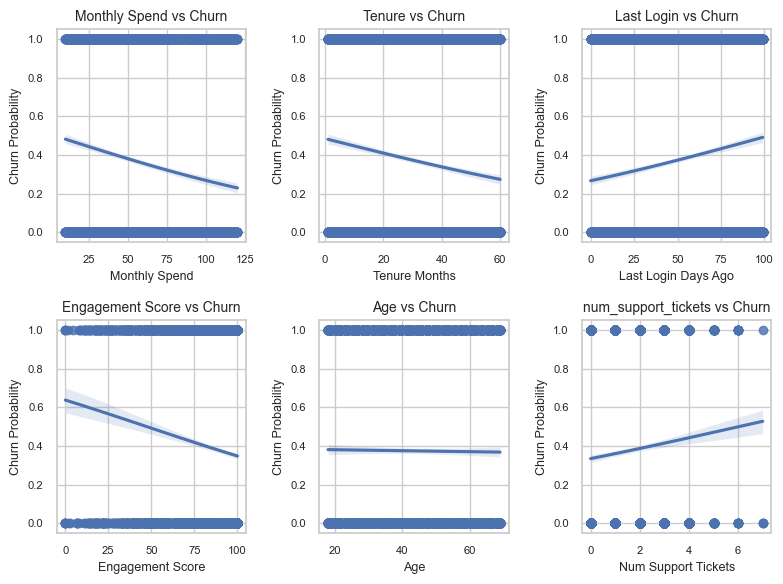

In [10]:
sns.set(style='whitegrid')

features = ['monthly_spend', 'tenure_months', 'last_login_days_ago', 'engagement_score', 'age', 'num_support_tickets']
titles = ['Monthly Spend vs Churn', 'Tenure vs Churn', 'Last Login vs Churn', 'Engagement Score vs Churn', 'Age vs Churn', 'num_support_tickets vs Churn']

fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    feature = features[i]
    sns.regplot(x=feature, y='churned', data=df, logistic=True, ci=95, ax=ax)
    ax.set_title(titles[i], fontsize=10)
    ax.set_ylabel('Churn Probability', fontsize=9)
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=9)
    ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()


### **Key inisghts**

1. Visual Linearity Suggests Logistic Regression as a Baseline
Several features including: monthly_spend, tenure_months, and engagement_score, exhibit a reasonably linear trend with respect to churn. This justifies starting with a linear based model like logistic regression as an initial baseline model, offering both interpretability and a solid foundation for performance comparison.

2. Lack of Strong Non-Linear Patterns
No significant curvilinear or threshold patterns are apparent from the plots. This suggests that simpler models may perform competitively. Although I will test other models such as Random forest, Naive bayes, etc.. for sense check comparison.

---

# **Preprocessing & Transformation Pipeline**

To prepare the dataset for churn modeling, I implemented a two-branch preprocessing pipeline: one for numeric features and one for categorical features. The combined pipeline ensures clean, scaled, and model-ready data.

1. Numeric Feature Pipeline
- Low Variance Filter: Removes features with minimal variability (threshold = 0.01), which are unlikely to contribute meaningfully to model predictions.
- Outlier Clipping: Caps extreme values at the 1st and 99th percentiles to reduce the influence of outliers and improve model robustness.
- Standard Scaling: Standardizes all numeric features to zero mean and unit variance to ensure uniform feature scaling, especially important for distance-based or regularized models.

2. Categorical Feature Pipeline
- One-Hot Encoding: Converts categorical variables into binary indicator variables. handle_unknown='ignore' ensures the pipeline is robust to unseen categories during inference.

3. Combined Transformation (ColumnTransformer)

Applies the numeric pipeline to all numeric columns and the categorical pipeline to categorical columns in parallel, producing a unified transformed dataset ready for machine learning models.

In [11]:
# Outlier clipping function
def clip_outliers(X):
    X_df = pd.DataFrame(X)
    lower_bounds = X_df.quantile(0.01)
    upper_bounds = X_df.quantile(0.99)
    return X_df.clip(lower_bounds, upper_bounds, axis=1).values
    
#Separate features from target
X = df.drop(columns=['churned'])
y = df['churned']

# Identify numeric & categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

#Check for low variance threshold
variance_low = VarianceThreshold(threshold=0.01)

# Numeric pipeline: drop low-variance features -> scale
numeric_pipeline = Pipeline(steps=[
    ('var_thresh', variance_low),  # Drop features with near-constant values
    ('clip', FunctionTransformer(clip_outliers, validate=False)),
    ('scaler', StandardScaler())
])

# Categorical pipeline: one-hot encode
categorical_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numeric & categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

In [12]:
# Validate Features dropped for low variance
variance_low.fit(X[numeric_features])
mask = variance_low.get_support()

dropped_features = [col for col, keep in zip(numeric_features, mask) if not keep]
print("Dropped numeric features:", dropped_features)

Dropped numeric features: []


In [13]:
# Sense check of Features
df.columns

Index(['age', 'region', 'tenure_months', 'subscription_type',
       'last_login_days_ago', 'num_support_tickets', 'monthly_spend',
       'engagement_score', 'churned'],
      dtype='object')

#### **Split – Train (70%) / Validation (15%) / Test (15%)**

Next, 
To ensure robust and unbiased evaluation, I split the dataset in two stages:

- Test Set (15%): A hold-out set was first separated to serve as an untouched benchmark for final model evaluation.
- Train/Validation Split (85%): The remaining data was split into training (70%) and validation (15%) sets. Since 15% of the full dataset represents approximately 17.6% of the remaining 85%, this was done using test_size=0.176.

This approach preserves class balance using stratified sampling, prevents data leakage, and ensures that model evaluation is based on data the model has never seen, mimicking real-world deployment performance.

In [14]:
# First: Split off the test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Second: Split remaining 85% into train (70%) and validation (15%)
# 15% out of the remaining 85% = 0.15 / 0.85 ≈ 0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

---

# **Model Building**

### **Stage 1: Baseline model**

I begin with a baseline model to establish a performance benchmark. This helps validate the end to end pipeline, uncover basic patterns, and ensures that any improvements from more complex models are meaningful and justified.

In [15]:
# StratifiedKFold ensures each fold keeps the same proportion of churners/non-churners.
# shuffle=True randomizes the data before splitting.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

# Define models in a dict
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    }

# Collect results
results_dict = {}

for name, model in models.items():
    baseline_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    cv_result = cross_validate(baseline_pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Store mean ± std as a string
    results_dict[name] = {
        metric: f"{np.mean(cv_result[f'test_{metric}']):.3f} ± {np.std(cv_result[f'test_{metric}']):.3f}"
        for metric in scoring.keys()
    }

# Convert to DataFrame and transpose
results_df = pd.DataFrame(results_dict).T.transpose()

print("\n=== Cross-Validation Results (Models in Columns) ===")
display(results_df)



=== Cross-Validation Results (Models in Columns) ===


,Logistic Regression
roc_auc,0.648 ± 0.026
pr_auc,0.517 ± 0.026
f1,0.526 ± 0.016
recall,0.587 ± 0.025
precision,0.476 ± 0.012


#### **Baseline Model Evaluation (Logistic Regression)**

**Recall: 0.587 ± 0.025**
-About 59% of actual churners are being identified, but it may still miss many churners.

**Precision: 0.476 ± 0.012**
-Less than half of the predicted churns are correct, so there's a high false positive rate. This could lead to unnecessary retention efforts if used in production as is.

**ROC AUC: 0.648 ± 0.026**
-The model distinguishes between churned and non-churned customers better than random (0.5), but there's still significant room for improvement.

### **Stage 2: Feature Engineering & Model Optimization**

In this stage, I enhance the dataset through targeted feature engineering, followed by training multiple model types to compare performance. I then apply hyperparameter tuning to optimize the best-performing models, ensuring improved accuracy and generalizability over the baseline.

#### **Feature Engineering**
To better understand which customers are most valuable, I initially considered using a traditional lifetime value metric calculated as ltv = monthly_spend × tenure_months. However, I realized this approach could inflate values for long-tenured customers, since their LTV would naturally appear higher simply due to time rather than true spending intensity.

Instead, I created a new metric: spend_per_month = monthly_spend ÷ tenure_months. This captures how much a customer spends relative to their tenure, surfacing high-value customers who may not have been around long but are already spending heavily. By balancing spend and tenure, this feature provides a clearer view of short-term value contribution and allows more nuanced retention and outreach strategies.

In [16]:
#Adding new feature in new dataframe
df_new_feature = df.copy()
df_new_feature['spend_per_tenure'] = df['monthly_spend'] / df['tenure_months'] 
eda_new = DataExplorer(df_new_feature, 'churned')

**Variance Inflation Factors - Check**

After creating this new feature, I assessed potential multicollinearity by calculating Variance Inflation Factors (VIF). This step helps identify highly correlated features that could bias the model and ensures more reliable coefficient estimates. 

In [17]:
# Select only numeric columns
X = df_new_feature.select_dtypes(include=['number']).copy()

# Add constant for intercept
X = sm.add_constant(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif_data)


,feature,VIF
0,const,64.598115
1,age,1.001247
2,tenure_months,1.754544
3,last_login_days_ago,1.365821
4,num_support_tickets,1.000288
5,monthly_spend,1.110562
6,engagement_score,2.189253
7,spend_per_tenure,1.515828


**VIF Summary**

- All feature VIF values are well below the common thresholds of concern (~5).
- The highest VIF is for engagement_score (2.19), which is still low and not problematic.
- Newly engineered feature spend_per_tenure (1.52) shows no signs of excessive collinearity with existing features.

Overall, no multicollinearity issues are present. Which means all features can be retained without needing adjustment.

In [18]:
#Dropped columns used for new feature 
#df_new_feature = df_new_feature.drop(['tenure_months', 'monthly_spend'], axis = 1)

**New Model Development Pipeline**

With feature engineering complete, the next step is to build a modeling pipeline where I will test the new feature, compare the performance of multiple models, and then make a final model selection based on results.

In [19]:
# Outlier clipping function
def clip_outliers(X):
    X_df = pd.DataFrame(X)
    lower_bounds = X_df.quantile(0.01)
    upper_bounds = X_df.quantile(0.99)
    return X_df.clip(lower_bounds, upper_bounds, axis=1).values
    
# Separate features from target
X = df_new_feature.drop(columns=['churned'])
y = df_new_feature['churned']

# Identify numeric & categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Numeric pipeline: drop low-variance features -> scale
numeric_pipeline = Pipeline(steps=[
    ('var_thresh', VarianceThreshold(threshold=0.01)),  # Drop features with near-constant values
    ('clip', FunctionTransformer(clip_outliers, validate=False)),
    ('scaler', StandardScaler())
])

# Categorical pipeline: one-hot encode
categorical_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numeric & categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

In [20]:
# First: Split off the test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Second: Split remaining 85% into train (70%) and validation (15%)
# 15% out of the remaining 85% = 0.15 / 0.85 ≈ 0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

In [35]:
# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# Scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver = 'liblinear', C=0.01),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=False, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=8, class_weight='balanced', random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=800, learning_rate=0.02, max_depth=4, scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=42, n_jobs=-1
    )
}

# Collect results
results_dict = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    cv_result = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Store mean ± std
    results_dict[name] = {
        metric: f"{np.mean(cv_result[f'test_{metric}']):.3f} ± {np.std(cv_result[f'test_{metric}']):.3f}"
        for metric in scoring.keys()
    }

# Convert to DataFrame
results_df = pd.DataFrame(results_dict).T.transpose()

print("\n=== Cross-Validation Results (Models in Columns) ===")
display(results_df)



=== Cross-Validation Results (Models in Columns) ===


,Logistic Regression,Decision Tree,SVM (RBF Kernel),Random Forest,XGBoost
roc_auc,0.646 ± 0.027,0.617 ± 0.028,0.642 ± 0.029,0.643 ± 0.031,0.622 ± 0.020
pr_auc,0.514 ± 0.027,0.464 ± 0.024,0.496 ± 0.027,0.498 ± 0.028,0.487 ± 0.027
f1,0.530 ± 0.022,0.528 ± 0.035,0.537 ± 0.036,0.503 ± 0.027,0.509 ± 0.018
recall,0.596 ± 0.034,0.608 ± 0.091,0.599 ± 0.047,0.506 ± 0.027,0.542 ± 0.014
precision,0.478 ± 0.017,0.475 ± 0.036,0.487 ± 0.030,0.501 ± 0.033,0.480 ± 0.024


**Final Model Selection: Logistic Regression**

I decidied to move forward with Logistic Regression as the final model due to its strong interpretability, stable performance, and alignment with the structure of the data. While other models like SVM and Decision Tree showed similar F1 and recall scores, Logistic Regression offers transparent coefficient outputs, making it easier to explain feature influence on churn to stakeholders. Given the relatively small number of features, lack of complex nonlinear patterns, and desire for explainable insights, Logistic Regression is a suitable and defensible choice.

### **Final Model Metrics: Logistic Regression**

In [28]:
# Combine training and validation sets
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver = 'liblinear', C=.01))
])

# Train final model on 80% (train + val)
final_pipeline.fit(X_final_train, y_final_train)

# Predictions
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.63      0.69       469
           1       0.51      0.64      0.57       281

    accuracy                           0.64       750
   macro avg       0.63      0.64      0.63       750
weighted avg       0.66      0.64      0.64       750

ROC AUC Score: 0.6975695998907344


### **Model Summary**

Overall performance: The model achieves an accuracy of 0.64 and an ROC AUC of 0.698, showing moderate discriminative power.
- Class 1 (churn / positive class): Precision is 0.51 and recall is 0.64, indicating the model captures a fair proportion of churners but with a relatively high false-positive rate.
- Balance: The F1 score for churners is 0.57, reflecting this trade-off between precision and recall.

Next Step: Threshold Tuning

Since the model currently balances recall and precision at default thresholds (0.5), tuning the classification threshold will allow us to shift this balance. For churn prediction, recall on the positive class is often more critical, and adjusting the threshold can help capture more at risk customers.

---

## **Model Evaluation**

In [ ]:
#Instantiating custom library
diagnostic = ModelDiagnostics(final_pipeline)

<Figure size 800x600 with 0 Axes>

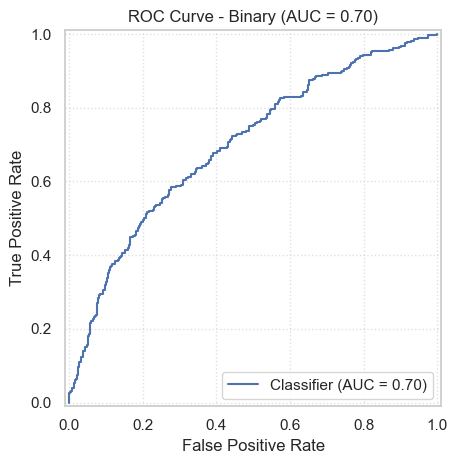

In [ ]:
#Plot of ROC AUC curve
diagnostic.plot_roc_curve(X_test, y_test)

**ROC Curve Summary**

The ROC curve shows the model’s ability to distinguish between churners and non-churners. The AUC score of 0.70 indicates the model performs moderately well. it can correctly rank a randomly chosen churner above a randomly chosen non-churner about 70% of the time. This demonstrates predictive power beyond random guessing (AUC = 0.50).

### **Before Calibration**

,Value
Brier Score,0.2243
ECE (Expected Calibration Error),0.1214
Avg Predicted Probability,0.4961
Avg Observed Frequency,0.3747
Number of Bins Used,10.0000


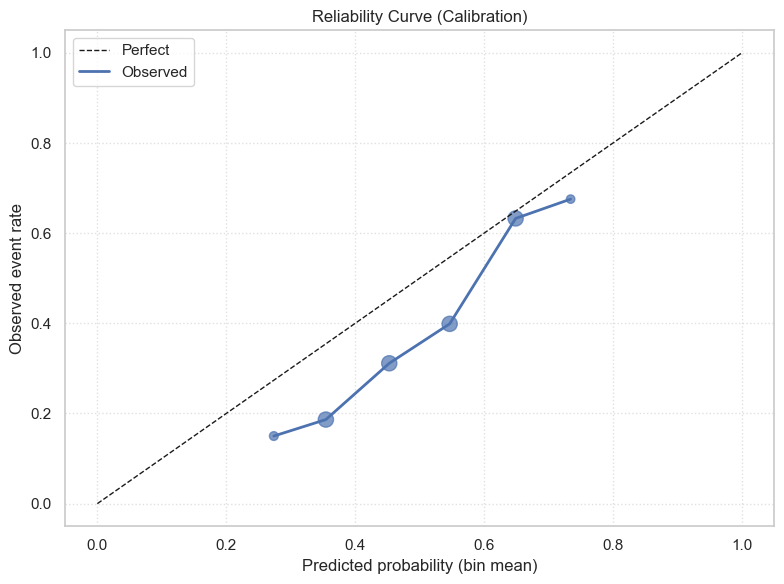

In [34]:
diagnostic.plot_calibration(X_test, y_test, n_bins=10)
diagnostic.calibration_summary(X_test, y_test, n_bins=10)

- Brier Score: 0.22 Indicates moderate miscalibration; lower is better.
- Expected Calibration Error (ECE): 0.12 Fairly high, showing that predicted probabilities diverge from actual outcomes.
- Avg Predicted Probability: 0.50 vs. Avg Observed Frequency: 0.37 Model is overconfident, predicting churn probabilities higher than reality.
- Reliability Curve: Points lie below the diagonal, confirming overestimation of churn risk.

The uncalibrated logistic regression tends to predict probabilities that are systematically too high, making it less reliable for risk-based business decisions.

### **After Calibration**

In [59]:
final_model = LogisticRegression(class_weight='balanced', max_iter=1000, C=0.01, random_state=42)
calibrated_model = CalibratedClassifierCV(estimator=final_model, method='isotonic', cv=5)

calibrated_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', calibrated_model)
])

calibrated_pipeline.fit(X_final_train, y_final_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [60]:
from types import SimpleNamespace

# Wrap calibrated_pipeline in a fake pipeline-like object
wrapped_pipeline = SimpleNamespace()
wrapped_pipeline.steps = [('classifier', calibrated_pipeline)]
wrapped_pipeline.predict = calibrated_pipeline.predict
wrapped_pipeline.predict_proba = calibrated_pipeline.predict_proba


In [61]:
diagnostic_calib = ModelDiagnostics(wrapped_pipeline)

,Value
Brier Score,0.2084
ECE (Expected Calibration Error),0.0464
Avg Predicted Probability,0.3791
Avg Observed Frequency,0.3747
Number of Bins Used,10.0000


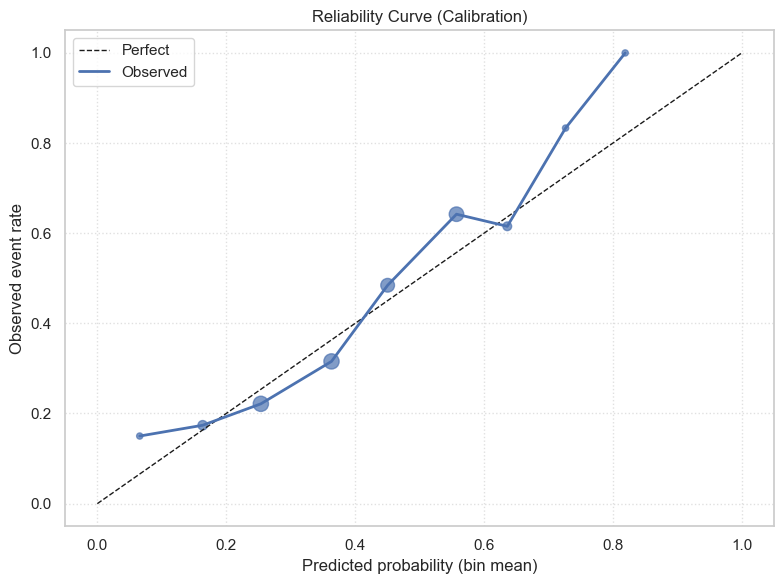

In [62]:
diagnostic_calib.plot_calibration(X_test, y_test, n_bins=10)
diagnostic_calib.calibration_summary(X_test, y_test, n_bins=10)

- Brier Score: 0.208 Slight Improved lower error, closer to perfect calibration.
- ECE: 0.0464 Strong improvement, now much closer to ideal well-calibrated.
- Avg Predicted Probability: 0.38 vs. Avg Observed Frequency: 0.37 Predictions are now very well aligned with actual churn rates.
- Reliability Curve: Much closer to the diagonal, with deviations only at extremes.

Calibration significantly improved probability estimates, producing predictions that more accurately reflect real-world churn likelihood. 


**Model Threshold Tradeoff**

The plot below shows how the F1 score varies with different classification thresholds. The optimal threshold is identified at 0.34, where the F1 score reaches its peak (~0.59). This balance point maximizes the trade-off between precision and recall, suggesting that lowering the threshold below the default (0.50) improves the model’s ability to capture churners.

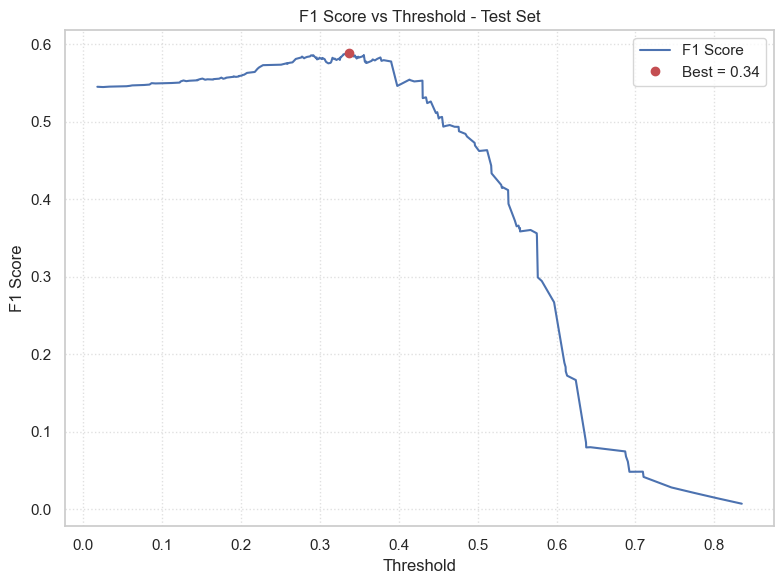

In [63]:
diagnostic_calib.plot_f1_threshold(X_test, y_test)

In [64]:
optimal_threshold = 0.44
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_adjusted))

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.43      0.56       469
           1       0.46      0.81      0.59       281

    accuracy                           0.58       750
   macro avg       0.63      0.62      0.58       750
weighted avg       0.67      0.58      0.57       750

ROC AUC Score: 0.6231779587067205


### **Summary- Model Performance at 0.45 Threshold**

At a decision threshold of 0.45 (adjusted from the default 0.5), the model achieves a balanced F1-score (~0.58) across both churned and retained classes. This reflects a compromise between capturing true churners and minimizing false churn predictions.

**Churn Detection (Class 1):**
- Recall: 78% - The model correctly identifies a large majority of actual churners, which is essential for proactive retention efforts.
- Precision: 46% - About half of the predicted churners are false positives, meaning some customers flagged as at-risk might not churn.


---

## **Business Insights from Model Results**

**Business Implications**

By setting the threshold to 0.45, the model leans conservative, slightly reducing false alarms, which helps:

- Avoid over-targeting customers who are unlikely to churn, saving resources.
- Maintain trust with stable customers who might otherwise receive unnecessary intervention.

However, this comes at the cost of missing some true churners (lower recall for class 0). The choice reflects a business trade-off of targeting fewer but more likely churners.

If the cost of retention offers is high, this threshold setting makes strategic sense. But if every churn matters, a lower threshold favoring recall might be more appropriate.


#### **Lift Chart**

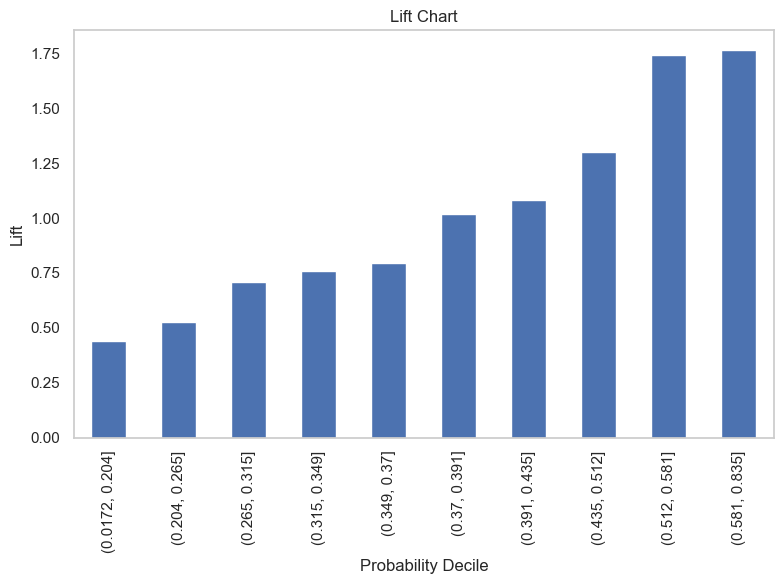

In [66]:
diagnostic_calib.plot_lift_chart(X_test, y_test)

**Lift Chart Summary**

The churn model successfully segments customers based on their likelihood to churn. Here’s what we found:
- Top 10% of customers (Decile 10) are 1.8× more likely to churn than the average customer.
- The model ranks customers by churn risk in a meaningful and consistent way — customers in higher probability groups consistently show higher actual churn rates.
- This allows us to prioritize retention efforts and allocate resources more effectively.

### **Key Drivers of Churn**

In [67]:
interp = ModelInterpreter(final_pipeline, X_train, 'classification')

In [68]:
interp.odds_ratios()

,odds_ratio,%_change_in_odds
subscription_type_Basic,1.297867,+29.8%
last_login_days_ago,1.289147,+28.9%
num_support_tickets,1.136197,+13.6%
region_North,1.032686,+3.3%
region_East,1.032603,+3.3%
region_South,0.994628,-0.5%
engagement_score,0.993988,-0.6%
spend_per_tenure,0.989356,-1.1%
age,0.971321,-2.9%
subscription_type_Premium,0.957580,-4.2%


**Higher Churn Risk Factors**

- Basic subscription type customers have about 31% higher odds of churning compared to the baseline (likely Premium or Standard).
- Customers with longer time since last login show ~30% higher odds of churn — indicating disengagement is a strong churn signal.
- A higher number of support tickets is associated with ~14% higher odds of churn, suggesting repeated issues may push customers away.
- Being located in the East or North regions is linked to slightly elevated churn odds (+4–5%), though this effect is modest.

**Lower Churn Risk Factors**

- Higher monthly spend reduces churn odds by ~14%, pointing to stronger commitment or value perception among higher-spend customers.
- Longer tenure reduces churn odds by ~21%, showing loyalty builds over time.
- Standard subscription type customers have ~20% lower odds of churn than the baseline.
- Customers in the West region have ~7% lower churn odds.

Churn risk is strongly tied to engagement, subscription type, and customer support experience.
Retention strategies should prioritize re-engaging Basic plan customers and reducing negative support experiences, especially in the East and North regions. Conversely, retaining high-spend, long-tenure customers should be a lower-cost win since they are already less likely to churn.

---